## Flower Recognition Using Transfer Learning

### 1. Let's first view the distribution of the data

In [3]:
data

,path,label
0,/kaggle/input/flowers-recognition/flowers/dand...,dandelion
1,/kaggle/input/flowers-recognition/flowers/dand...,dandelion
2,/kaggle/input/flowers-recognition/flowers/dand...,dandelion
3,/kaggle/input/flowers-recognition/flowers/dand...,dandelion
4,/kaggle/input/flowers-recognition/flowers/dand...,dandelion
...,...,...
4312,/kaggle/input/flowers-recognition/flowers/rose...,rose
4313,/kaggle/input/flowers-recognition/flowers/rose...,rose
4314,/kaggle/input/flowers-recognition/flowers/rose...,rose
4315,/kaggle/input/flowers-recognition/flowers/rose...,rose


<Axes: >

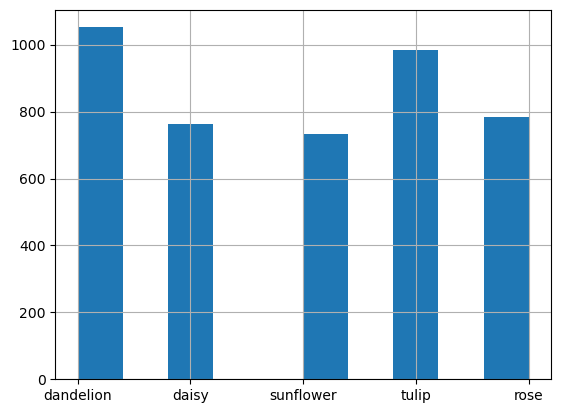

In [4]:
data.label.hist()

### Is the data imbalance?

### 2. Data Loader and Custom Data Class

### Define Data Transform Strategy

In [1]:
import os
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
from utils.utils import get_dataloader
from torchvision import datasets, transforms
batch_size = 4
data_path = "/home/endtheme/git/bird-class/data/"
import torchvision.transforms as transform
from torchvision.transforms import v2
import torchvision
train_transformer = transform.Compose([
                           transform.Resize((256, 256)),
                           transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transform.RandomRotation(5),
                           transform.RandomGrayscale(),
                           transform.RandomResizedCrop(224),
                           transform.RandomHorizontalFlip(),
                           
                           transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transform.ToTensor(),
                           transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                               (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
])


test_transformer = transform.Compose([
                           transform.Resize((256, 256)),
                           
                           transform.ToTensor(),
                           transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), 
                                               (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))
])
shuffle = True
compact = False

train_loader,test_loader = get_dataloader(data_path = data_path, train_transform = train_transformer, test_transform = test_transformer, batch_size = batch_size, shuffle = shuffle, compact = compact)




## 3. Define Metrics  and Loss function

In [4]:
from sklearn import metrics as skmetrics
import numpy
class Metrics:
    def __init__(self, metric_names):
        self.metric_names = metric_names
        # initialize a metric dictionary
        self.metric_dict = {metric_name: [0] for metric_name in self.metric_names}

    def step(self, labels, preds):
        for metric in self.metric_names:
            # get the metric function
            do_metric = getattr(
                skmetrics, metric, "The metric {} is not implemented".format(metric)
            )
            # check if metric require average method, if yes set to 'micro' or 'macro' or 'None'
            try:
                self.metric_dict[metric].append(
                    do_metric(labels, preds, average="macro")
                )
            except:
                self.metric_dict[metric].append(do_metric(labels, preds))

    def epoch(self):
        # calculate metrics for an entire epoch
        avg = [sum(metric) / (len(metric) - 1) for metric in self.metric_dict.values()]
        metric_as_dict = dict(zip(self.metric_names, avg))
        return metric_as_dict

    def last_step_metrics(self):
        # return metrics of last steps
        values = [self.metric_dict[metric][-1] for metric in self.metric_names]
        metric_as_dict = dict(zip(self.metric_names, values))
        return metric_as_dict

In [5]:
train_metrics = Metrics(["accuracy_score","f1_score"])
val_metrics = Metrics(["accuracy_score","f1_score"])

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
criterion = nn.CrossEntropyLoss()

In [7]:
device

device(type='cuda')

## 4. Define the Model: Transfer Learning

In [17]:
from torchvision import models
from torch import nn
model = models.efficientnet_b4(pretrained=True).cuda()
for param in model.parameters():
    param.requires_grad = False
classifier = nn.Sequential(
    nn.Linear(in_features=model.classifier[1].in_features, out_features=256,bias=True),
    nn.Dropout(),
    nn.Linear(in_features=256, out_features=200,bias=True)
)
model.classifier  = classifier

In [18]:
len(model.features)

9

In [19]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.5
    )

## 5. Define a training epoch

In [20]:
model = model.to(device)

In [21]:
def train_one_epoch(
    model,
    train_loader,
    test_loader,
    device,
    optimizer,
    criterion,
    train_metrics,
    val_metrics,
):

    # training-the-model
    train_loss = 0
    valid_loss = 0
    all_labels = []
    all_preds = []
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU
        data = data.type(torch.FloatTensor).to(device)
        # target=torch.Tensor(target)
        target = target.float().to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # get the prediction label and target label
        output = model(data)
        preds = torch.argmax(output, axis=1).cpu().detach().numpy()
        labels = target.cpu().numpy()
        # calculate-the-batch-loss
        loss = criterion(output.type(torch.FloatTensor), target.type(torch.LongTensor))
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        # calculate training metrics
        all_labels.extend(labels)
        all_preds.extend(preds)
    
    train_metrics.step(all_labels, all_preds)

    # validate-the-model
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.type(torch.FloatTensor).to(device)
            target = target.to(device)
            output = model(data)
            preds = torch.argmax(output, axis=1).tolist()
            labels = target.tolist()
            all_labels.extend(labels)
            all_preds.extend(preds)
            loss = criterion(output, target)

            # update-average-validation-loss
            valid_loss += loss.item() * data.size(0)

    val_metrics.step(all_labels, all_preds)
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(test_loader.sampler)

    return (
        train_loss,
        valid_loss,
        train_metrics.last_step_metrics(),
        val_metrics.last_step_metrics(),
    )

## 6. Begin Training

In [22]:
from tqdm import tqdm

In [23]:

from datetime import datetime
time_str = str(datetime.now().strftime("%Y%m%d-%H%M"))

In [24]:
num_epoch = 10
best_val_acc = 0
import logging
import numpy as np
print("begin training process")
for i in tqdm(range(0, num_epoch)):
    loss, val_loss, train_result, val_result = train_one_epoch(
        model,
        train_loader,
        test_loader,
        device,
        optimizer,
        criterion,
        train_metrics,
        val_metrics,
    )

    scheduler.step(val_loss)
    print(
        "Epoch {} / {} \n Training loss: {} - Other training metrics: ".format(
            i + 1, num_epoch, loss
        )
    )
    print(train_result)
    print(
        " \n Validation loss : {} - Other validation metrics:".format(val_loss)
    )
    print(val_result)
    print("\n")
    # saving epoch with best validation accuracy
    if best_val_acc < float(val_result["accuracy_score"]):
        print(
            "Validation accuracy= "+
            str(val_result["accuracy_score"])+
            "===> Save best epoch"
        )
        best_val_acc = val_result["accuracy_score"]
        torch.save(
            model.state_dict(),
            "./" +  "best.pt",
        )
    else:
        print(
            "Validation accuracy= "+ str(val_result["accuracy_score"])+ "===> No saving"
        )
        continue

begin training process


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10 
 Training loss: 4.941287822273114 - Other training metrics: 
{'accuracy_score': 0.040795195692689995, 'f1_score': 0.03208454491323702}
 
 Validation loss : 7.143192449677426 - Other validation metrics:
{'accuracy_score': 0.07807308970099668, 'f1_score': 0.060139227655620214}


Validation accuracy= 0.07807308970099668===> Save best epoch


 10%|█         | 1/10 [05:58<53:43, 358.15s/it]

Epoch 2 / 10 
 Training loss: 4.176376114476169 - Other training metrics: 
{'accuracy_score': 0.11306688755435908, 'f1_score': 0.09658768241077847}
 
 Validation loss : 6.6272841537513605 - Other validation metrics:
{'accuracy_score': 0.11461794019933555, 'f1_score': 0.10691481158947656}


Validation accuracy= 0.11461794019933555===> Save best epoch


 20%|██        | 2/10 [11:26<45:25, 340.70s/it]

Epoch 3 / 10 
 Training loss: 3.892877298399735 - Other training metrics: 
{'accuracy_score': 0.153033754400497, 'f1_score': 0.14063456971941027}
 
 Validation loss : 8.212297569873721 - Other validation metrics:
{'accuracy_score': 0.1669435215946844, 'f1_score': 0.16054304124562166}


Validation accuracy= 0.1669435215946844===> Save best epoch


 40%|████      | 4/10 [21:49<32:19, 323.24s/it]

Epoch 4 / 10 
 Training loss: 3.7489409456590757 - Other training metrics: 
{'accuracy_score': 0.18016152412507766, 'f1_score': 0.16790373818270488}
 
 Validation loss : 12.915653088164092 - Other validation metrics:
{'accuracy_score': 0.15199335548172757, 'f1_score': 0.15094732972700897}


Validation accuracy= 0.15199335548172757===> No saving


In [29]:
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

model = model.to(device)
num_epoch = 20
best_val_acc = 0.8528
import logging
import numpy as np
print("begin training process")
for i in tqdm(range(0, num_epoch)):
    loss, val_loss, train_result, val_result = train_one_epoch(
        model,
        train_loader,
        val_loader,
        device,
        optimizer,
        criterion,
        train_metrics,
        val_metrics,
    )

    scheduler.step(val_loss)
    print(
        "Epoch {} / {} \n Training loss: {} - Other training metrics: ".format(
            i + 1, num_epoch, loss
        )
    )
    print(train_result)
    print(
        " \n Validation loss : {} - Other validation metrics:".format(val_loss)
    )
    print(val_result)
    print("\n")
    # saving epoch with best validation accuracy
    if best_val_acc < float(val_result["accuracy_score"]):
        print(
            "Validation accuracy= "+
            str(val_result["accuracy_score"])+
            "===> Save best epoch"
        )
        best_val_acc = val_result["accuracy_score"]
        torch.save(
            model,
            "./" +  "best.pt"
        )
    else:
        print(
            "Validation accuracy= "+ str(val_result["accuracy_score"])+ "===> No saving"
        )
        continue

begin training process


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20 
 Training loss: 0.47818567297908643 - Other training metrics: 
{'accuracy_score': 0.8290562913907285, 'f1_score': 0.8267146153803792}
 
 Validation loss : 0.38244324899092424 - Other validation metrics:
{'accuracy_score': 0.8743801652892562, 'f1_score': 0.8738287329000729}


Validation accuracy= 0.8743801652892562===> Save best epoch


  5%|▌         | 1/20 [00:56<18:00, 56.85s/it]

Epoch 2 / 20 
 Training loss: 0.34912917400334054 - Other training metrics: 
{'accuracy_score': 0.8708609271523179, 'f1_score': 0.8686999561388724}
 
 Validation loss : 0.30876828469902257 - Other validation metrics:
{'accuracy_score': 0.9090909090909091, 'f1_score': 0.907878440051614}


Validation accuracy= 0.9090909090909091===> Save best epoch


 15%|█▌        | 3/20 [02:49<15:58, 56.36s/it]

Epoch 3 / 20 
 Training loss: 0.2894299645346916 - Other training metrics: 
{'accuracy_score': 0.8940397350993378, 'f1_score': 0.8929670918629892}
 
 Validation loss : 0.3048200643084506 - Other validation metrics:
{'accuracy_score': 0.8942148760330578, 'f1_score': 0.8939431006916072}


Validation accuracy= 0.8942148760330578===> No saving


 20%|██        | 4/20 [03:45<14:57, 56.11s/it]

Epoch 4 / 20 
 Training loss: 0.2488753136728477 - Other training metrics: 
{'accuracy_score': 0.9134933774834437, 'f1_score': 0.9122289153637375}
 
 Validation loss : 0.31982426483044535 - Other validation metrics:
{'accuracy_score': 0.9008264462809917, 'f1_score': 0.9005306314603935}


Validation accuracy= 0.9008264462809917===> No saving


 25%|██▌       | 5/20 [04:40<13:59, 55.99s/it]

Epoch 5 / 20 
 Training loss: 0.20760340492753004 - Other training metrics: 
{'accuracy_score': 0.929635761589404, 'f1_score': 0.9287262667350789}
 
 Validation loss : 0.28564413460840404 - Other validation metrics:
{'accuracy_score': 0.9041322314049587, 'f1_score': 0.9031958846122302}


Validation accuracy= 0.9041322314049587===> No saving


 30%|███       | 6/20 [05:35<12:57, 55.55s/it]

Epoch 6 / 20 
 Training loss: 0.17843304196409634 - Other training metrics: 
{'accuracy_score': 0.9366721854304636, 'f1_score': 0.9353559995467142}
 
 Validation loss : 0.3317030043590648 - Other validation metrics:
{'accuracy_score': 0.8991735537190083, 'f1_score': 0.8968533203130494}


Validation accuracy= 0.8991735537190083===> No saving


 35%|███▌      | 7/20 [06:30<12:00, 55.42s/it]

Epoch 7 / 20 
 Training loss: 0.16896408004686236 - Other training metrics: 
{'accuracy_score': 0.9416390728476821, 'f1_score': 0.9416036043961459}
 
 Validation loss : 0.29803757471815434 - Other validation metrics:
{'accuracy_score': 0.9090909090909091, 'f1_score': 0.9094374821212318}


Validation accuracy= 0.9090909090909091===> No saving


 40%|████      | 8/20 [07:25<11:02, 55.17s/it]

Epoch 8 / 20 
 Training loss: 0.1567002411728219 - Other training metrics: 
{'accuracy_score': 0.9478476821192053, 'f1_score': 0.9473758039006407}
 
 Validation loss : 0.2971341186653516 - Other validation metrics:
{'accuracy_score': 0.9090909090909091, 'f1_score': 0.9098882841404379}


Validation accuracy= 0.9090909090909091===> No saving


 45%|████▌     | 9/20 [08:20<10:06, 55.14s/it]

Epoch 9 / 20 
 Training loss: 0.18234558494465536 - Other training metrics: 
{'accuracy_score': 0.9416390728476821, 'f1_score': 0.9412005026363739}
 
 Validation loss : 0.3047923027162623 - Other validation metrics:
{'accuracy_score': 0.9074380165289256, 'f1_score': 0.9059670497500691}


Validation accuracy= 0.9074380165289256===> No saving
Epoch 10 / 20 
 Training loss: 0.15636841749575064 - Other training metrics: 
{'accuracy_score': 0.9432947019867549, 'f1_score': 0.942718717943251}
 
 Validation loss : 0.2823326615618721 - Other validation metrics:
{'accuracy_score': 0.9107438016528926, 'f1_score': 0.9123230317623043}


Validation accuracy= 0.9107438016528926===> Save best epoch


 55%|█████▌    | 11/20 [10:10<08:14, 54.99s/it]

Epoch 11 / 20 
 Training loss: 0.13574345884262584 - Other training metrics: 
{'accuracy_score': 0.9490894039735099, 'f1_score': 0.9482557399322094}
 
 Validation loss : 0.3167481279891107 - Other validation metrics:
{'accuracy_score': 0.9041322314049587, 'f1_score': 0.9045890575113921}


Validation accuracy= 0.9041322314049587===> No saving


 60%|██████    | 12/20 [11:03<07:17, 54.63s/it]

Epoch 12 / 20 
 Training loss: 0.13725018043484266 - Other training metrics: 
{'accuracy_score': 0.9519867549668874, 'f1_score': 0.9514462662524364}
 
 Validation loss : 0.3222608580039759 - Other validation metrics:
{'accuracy_score': 0.9107438016528926, 'f1_score': 0.9100387553973203}


Validation accuracy= 0.9107438016528926===> No saving


 65%|██████▌   | 13/20 [11:59<06:23, 54.81s/it]

Epoch 13 / 20 
 Training loss: 0.12850297120899357 - Other training metrics: 
{'accuracy_score': 0.9565397350993378, 'f1_score': 0.9558446832180595}
 
 Validation loss : 0.38766300845042073 - Other validation metrics:
{'accuracy_score': 0.8876033057851239, 'f1_score': 0.885247073101778}


Validation accuracy= 0.8876033057851239===> No saving


 70%|███████   | 14/20 [12:53<05:28, 54.76s/it]

Epoch 14 / 20 
 Training loss: 0.12906037304097084 - Other training metrics: 
{'accuracy_score': 0.9557119205298014, 'f1_score': 0.9551214016958097}
 
 Validation loss : 0.35196611423797874 - Other validation metrics:
{'accuracy_score': 0.9024793388429752, 'f1_score': 0.9022487004384416}


Validation accuracy= 0.9024793388429752===> No saving


 75%|███████▌  | 15/20 [13:50<04:36, 55.25s/it]

Epoch 15 / 20 
 Training loss: 0.12362158955872793 - Other training metrics: 
{'accuracy_score': 0.9577814569536424, 'f1_score': 0.9574670229293247}
 
 Validation loss : 0.2803004293639789 - Other validation metrics:
{'accuracy_score': 0.9090909090909091, 'f1_score': 0.9087569734224734}


Validation accuracy= 0.9090909090909091===> No saving
Epoch 16 / 20 
 Training loss: 0.12519847152489452 - Other training metrics: 
{'accuracy_score': 0.9577814569536424, 'f1_score': 0.9573007635899129}
 
 Validation loss : 0.2512230329069845 - Other validation metrics:
{'accuracy_score': 0.9338842975206612, 'f1_score': 0.9327230515657103}


Validation accuracy= 0.9338842975206612===> Save best epoch


 85%|████████▌ | 17/20 [15:41<02:45, 55.33s/it]

Epoch 17 / 20 
 Training loss: 0.13536126842793225 - Other training metrics: 
{'accuracy_score': 0.9474337748344371, 'f1_score': 0.9472646081618175}
 
 Validation loss : 0.2477417660163516 - Other validation metrics:
{'accuracy_score': 0.9272727272727272, 'f1_score': 0.9272734974930026}


Validation accuracy= 0.9272727272727272===> No saving


 90%|█████████ | 18/20 [16:36<01:50, 55.30s/it]

Epoch 18 / 20 
 Training loss: 0.11381143375703855 - Other training metrics: 
{'accuracy_score': 0.9623344370860927, 'f1_score': 0.9617090457889488}
 
 Validation loss : 0.30299073813636046 - Other validation metrics:
{'accuracy_score': 0.9223140495867769, 'f1_score': 0.9214896792330547}


Validation accuracy= 0.9223140495867769===> No saving


 95%|█████████▌| 19/20 [17:31<00:55, 55.11s/it]

Epoch 19 / 20 
 Training loss: 0.11716960393129817 - Other training metrics: 
{'accuracy_score': 0.9565397350993378, 'f1_score': 0.955506860337062}
 
 Validation loss : 0.3065448797671154 - Other validation metrics:
{'accuracy_score': 0.9024793388429752, 'f1_score': 0.9023344667574944}


Validation accuracy= 0.9024793388429752===> No saving


100%|██████████| 20/20 [18:25<00:00, 55.29s/it]

Epoch 20 / 20 
 Training loss: 0.09672313036484989 - Other training metrics: 
{'accuracy_score': 0.9685430463576159, 'f1_score': 0.9681276193237915}
 
 Validation loss : 0.3179924247966974 - Other validation metrics:
{'accuracy_score': 0.9223140495867769, 'f1_score': 0.9216985211616059}


Validation accuracy= 0.9223140495867769===> No saving


## Test the results

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [31]:
import copy
test_model = torch.load("/kaggle/working/best.pt")
test_model = test_model.to(device)


In [32]:
x_train.dtypes


path     object
label     int64
dtype: object

In [33]:
def test_result(model, test_loader, device):
    # testing the model by turning model "Eval" mode
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for data, target in test_loader:
            # move-tensors-to-GPU
            data = data.to(device)
            print(target)
            target = target.to(device)
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            prob = nn.Softmax(dim=1)
            # applying Softmax to results
            probs = prob(output)
            labels.extend(target.tolist())
            preds.extend(torch.argmax(probs, axis=1).tolist())
    return labels,preds


In [34]:
test_loader

In [35]:
for data, target in test_loader:
            # move-tensors-to-GPU
            
            print(target)

tensor([4])
tensor([1])
tensor([1])
tensor([3])
tensor([2])
tensor([0])
tensor([4])
tensor([0])
tensor([2])
tensor([3])
tensor([0])
tensor([0])
tensor([0])
tensor([4])
tensor([0])
tensor([2])
tensor([0])
tensor([0])
tensor([4])
tensor([3])
tensor([4])
tensor([1])
tensor([4])
tensor([0])
tensor([2])
tensor([4])
tensor([4])
tensor([1])
tensor([3])
tensor([1])
tensor([3])
tensor([1])
tensor([1])
tensor([4])
tensor([0])
tensor([2])
tensor([2])
tensor([3])
tensor([2])
tensor([0])
tensor([2])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([2])
tensor([2])
tensor([1])
tensor([2])
tensor([3])
tensor([3])
tensor([1])
tensor([1])
tensor([0])
tensor([3])
tensor([3])
tensor([3])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([3])
tensor([2])
tensor([1])
tensor([0])
tensor([2])
tensor([0])
tensor([0])
tensor([4])
tensor([0])
tensor([1])
tensor([4])
tensor([4])
tensor([4])
tensor([1])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([1])
tens

In [36]:
labels,preds =test_result(test_model, test_loader, device)

tensor([4])
tensor([1])
tensor([1])
tensor([3])
tensor([2])
tensor([0])
tensor([4])
tensor([0])
tensor([2])
tensor([3])
tensor([0])
tensor([0])
tensor([0])
tensor([4])
tensor([0])
tensor([2])
tensor([0])
tensor([0])
tensor([4])
tensor([3])
tensor([4])
tensor([1])
tensor([4])
tensor([0])
tensor([2])
tensor([4])
tensor([4])
tensor([1])
tensor([3])
tensor([1])
tensor([3])
tensor([1])
tensor([1])
tensor([4])
tensor([0])
tensor([2])
tensor([2])
tensor([3])
tensor([2])
tensor([0])
tensor([2])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([2])
tensor([2])
tensor([1])
tensor([2])
tensor([3])
tensor([3])
tensor([1])
tensor([1])
tensor([0])
tensor([3])
tensor([3])
tensor([3])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([3])
tensor([2])
tensor([1])
tensor([0])
tensor([2])
tensor([0])
tensor([0])
tensor([4])
tensor([0])
tensor([1])
tensor([4])
tensor([4])
tensor([4])
tensor([1])
tensor([1])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([1])
tens

In [37]:
# bpreds = []
# for pred in preds:
#     bpred = [pred]
#     bpreds.append(bpred)
    
# bpreds

In [38]:
report = classification_report(labels, preds, digits=4,target_names=le.classes_)

cm = confusion_matrix(labels, preds)

In [39]:
print(report)

              precision    recall  f1-score   support

       daisy     0.9556    0.9389    0.9471       229
   dandelion     0.9590    0.9620    0.9605       316
        rose     0.9730    0.9191    0.9453       235
   sunflower     0.9195    0.9864    0.9518       220
       tulip     0.9527    0.9527    0.9527       296

    accuracy                         0.9522      1296
   macro avg     0.9519    0.9518    0.9515      1296
weighted avg     0.9528    0.9522    0.9521      1296



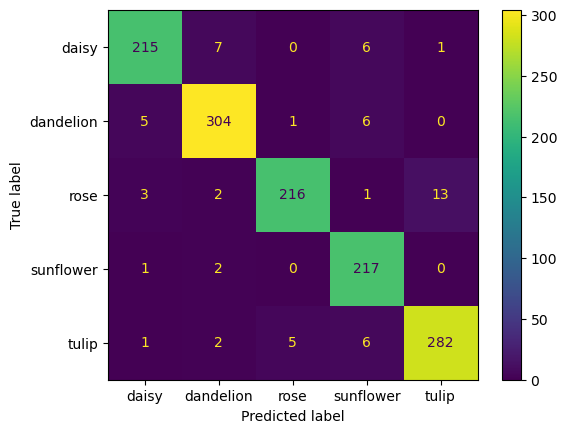

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
disp.plot()

<Axes: >

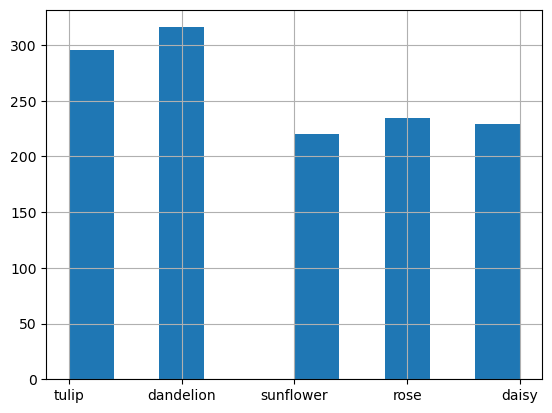

In [41]:
x_test.label = le.inverse_transform(x_test.label)
x_test.label.hist()

How mixcut work and why we need it?

MixCut: cut a part of the image and paste it into other image, the cut part will also has the label comning along with it
=> it helps the model to focus on less discriminative parts of the object or in other words, prevents model from making prediction solely based on a part of the object